In [1]:
! pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 11.4 MB/s eta 0:00:00


In [2]:
! pip install matplotlib seaborn pandas numpy scipy

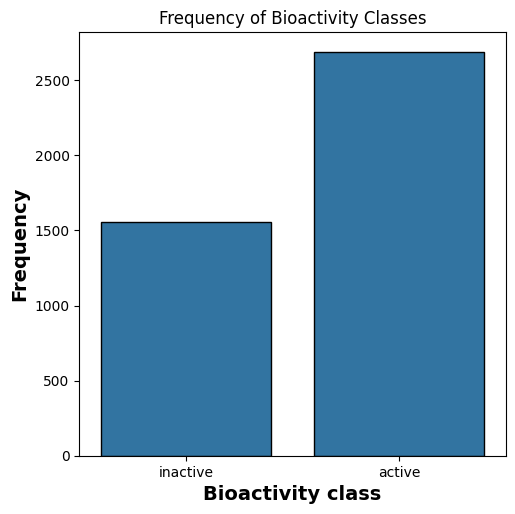

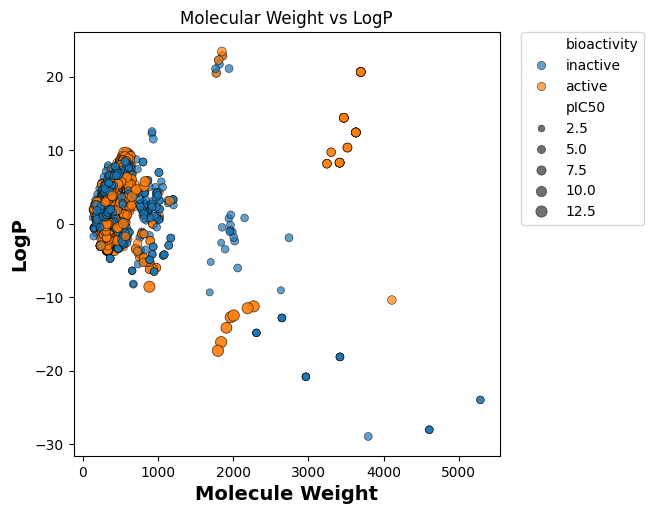

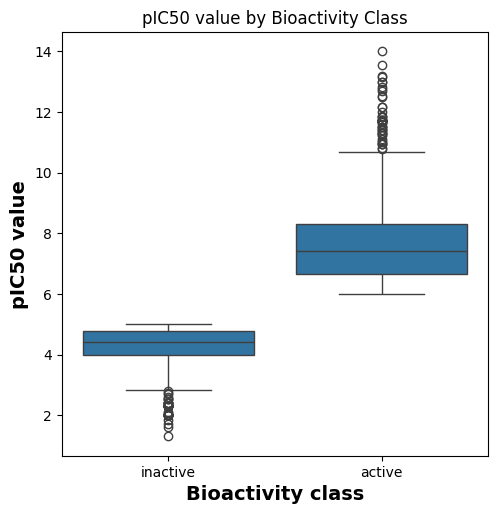

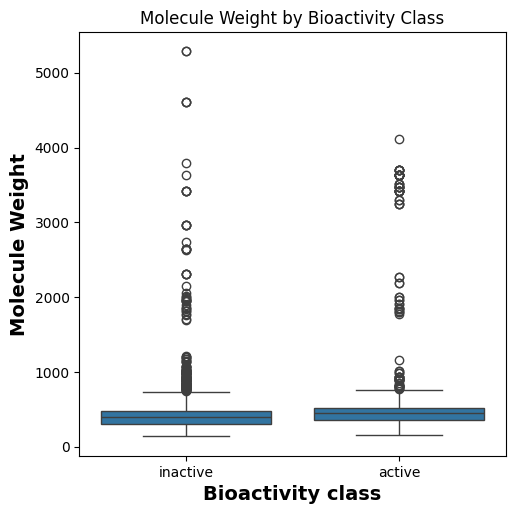

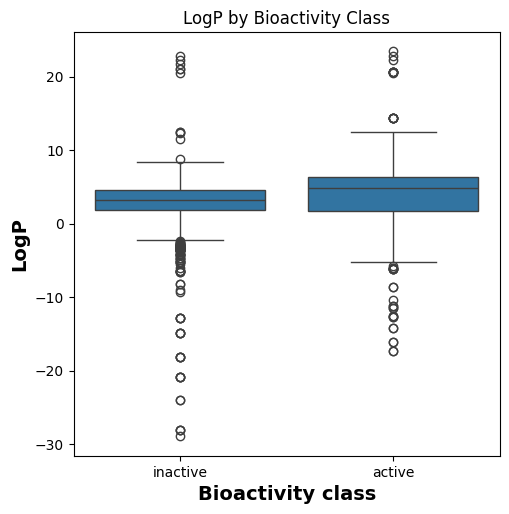

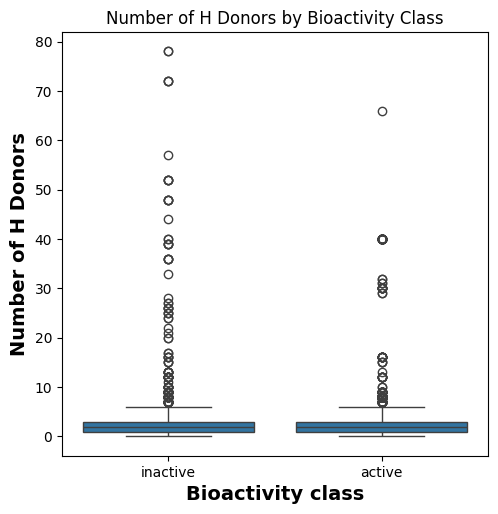

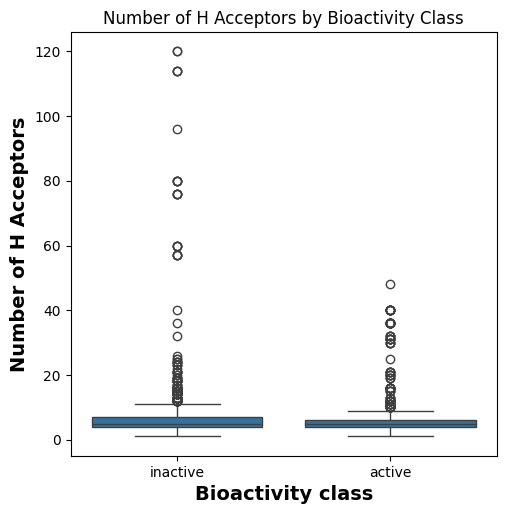

pIC50: Statistics=4176730.000, p=0.000, Interpretation=Different distribution (reject H0)
MoleculeWeight: Statistics=2577464.000, p=0.000, Interpretation=Different distribution (reject H0)
LogP: Statistics=2634358.000, p=0.000, Interpretation=Different distribution (reject H0)
NumHDonors: Statistics=2166395.500, p=0.036, Interpretation=Different distribution (reject H0)
NumHAcceptors: Statistics=2113430.500, p=0.509, Interpretation=Same distribution (fail to reject H0)


In [6]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

df = pd.read_csv("bioactivity_data_combined.csv")

"""Calculating Lipinski Rule of 5 Descriptors"""
def lipinski(smiles, verbose=False):
    moldata = [Chem.MolFromSmiles(elem) for elem in smiles if Chem.MolFromSmiles(elem) is not None]
    baseData = []

    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = [desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors]
        baseData.append(row)

    columnNames = ["MoleculeWeight", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors

#Generating Lipinski descriptors and merge with the original dataset
df_lipinski = lipinski(df.canonical_smiles)
both_dfs = pd.concat([df.reset_index(drop=True), df_lipinski], axis=1)

"""Normalize 'standard_value' and calculate pIC50"""
def norm_value(input_df):
    input_df['standard_value_norm'] = input_df['standard_value'].apply(lambda x: min(x, 100000000))
    return input_df.drop(columns=['standard_value'])

def pIC50(input_df):
    input_df['pIC50'] = -np.log10(input_df['standard_value_norm'] * 1e-9)
    return input_df.drop(columns=['standard_value_norm'])

#Normalize and calculate pIC50
df_norm = norm_value(both_dfs)
final_df = pIC50(df_norm)

#Filter out intermediate classes
pro_df = final_df[final_df.bioactivity != 'intermediate']

"""Exploratory Data Analysis via Lipinski Descriptors"""
#Frequency plot of bioactivity classes
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='bioactivity', data=pro_df, edgecolor='black')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Frequency of Bioactivity Classes')
plt.savefig('plot_bioactivity.pdf')
plt.show()

#Scatter plot between Molecular Weight and LogP
plt.figure(figsize=(5.5, 5.5))
sns.scatterplot(x='MoleculeWeight', y='LogP', data=pro_df, hue='bioactivity', size='pIC50', edgecolor='black', alpha=0.7)
plt.xlabel('Molecule Weight', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.title('Molecular Weight vs LogP')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_LogP.pdf')
plt.show()

#Box plots for pIC50, Molecular Weight, LogP, NumHDonors, and NumHAcceptors
def plot_boxplot(descriptor, ylabel):
    plt.figure(figsize=(5.5, 5.5))
    sns.boxplot(x='bioactivity', y=descriptor, data=pro_df)
    plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold')
    plt.title(f'{ylabel} by Bioactivity Class')
    plt.savefig(f'plot_{descriptor}.pdf')
    plt.show()

plot_boxplot('pIC50', 'pIC50 value')
plot_boxplot('MoleculeWeight', 'Molecule Weight')
plot_boxplot('LogP', 'LogP')
plot_boxplot('NumHDonors', 'Number of H Donors')
plot_boxplot('NumHAcceptors', 'Number of H Acceptors')

"""Mann-Whitney U Test for Statistical Analysis"""
def mannwhitney(descriptor):
    active = pro_df[pro_df.bioactivity == 'active'][descriptor]
    inactive = pro_df[pro_df.bioactivity == 'inactive'][descriptor]

    stat, p = mannwhitneyu(active, inactive)
    interpretation = 'Different distribution (reject H0)' if p <= 0.05 else 'Same distribution (fail to reject H0)'

    results = pd.DataFrame({'Descriptor': [descriptor], 'Statistics': [stat], 'p': [p], 'alpha': [0.05], 'Interpretation': [interpretation]})
    filename = f'mannwhitneyu_{descriptor}.csv'
    results.to_csv(filename, index=False)

    print(f'{descriptor}: Statistics={stat:.3f}, p={p:.3f}, Interpretation={interpretation}')
    return results

mannwhitney('pIC50')
mannwhitney('MoleculeWeight')
mannwhitney('LogP')
mannwhitney('NumHDonors')
mannwhitney('NumHAcceptors')

pro_df.to_csv('processed_bioactivity_data.csv', index=False)
